<a href="https://colab.research.google.com/github/brunotagoncalves/MeLi_2021_demand_prediction/blob/main/meli_EDA_11th_sub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read Data 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install catboost

     |████████████████████████████████| 69.2 MB 4.8 kB/s 


In [3]:
#!wget https://meli-data-challenge.s3.amazonaws.com/2021/test_data.csv -P drive/MyDrive/MeLi-2021/row/
#!wget https://meli-data-challenge.s3.amazonaws.com/2021/train_data.parquet -P drive/MyDrive/MeLi-2021/row/
#!wget https://meli-data-challenge.s3.amazonaws.com/2021/items_static_metadata_full.jl -P drive/MyDrive/MeLi-2021/row/
#!wget https://meli-data-challenge.s3.amazonaws.com/2021/sample_submission.csv.gz -P drive/MyDrive/MeLi-2021/row/

In [4]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget http://www-eu.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz 
!wget -P spark_tgz/ http://www-eu.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz

--2021-08-03 17:23:32--  http://www-eu.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
Resolving www-eu.apache.org (www-eu.apache.org)... 95.216.26.30, 2a01:4f9:2a:1a61::2
Connecting to www-eu.apache.org (www-eu.apache.org)|95.216.26.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz [following]
--2021-08-03 17:23:32--  https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
Resolving downloads.apache.org (downloads.apache.org)... 135.181.214.104, 135.181.209.10, 88.99.95.219, ...
Connecting to downloads.apache.org (downloads.apache.org)|135.181.214.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 235899716 (225M) [application/x-gzip]
Saving to: ‘spark_tgz/spark-2.4.8-bin-hadoop2.7.tgz’

spark-2.4.8-bin-had 100%[===================>] 224.97M  24.9MB/s    in 9.8s    

2021-08-03 17:23:42 (23.0 MB/s) - ‘spark_tgz/spar

In [5]:
!tar -xf spark_tgz/spark-2.4.8-bin-hadoop2.7.tgz -C spark_tgz/
!pip install -q findspark
!pip install -q pyspark

     |████████████████████████████████| 212.4 MB 41 kB/s 
     |████████████████████████████████| 198 kB 50.1 MB/s 


In [6]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark_tgz/spark-2.4.8-bin-hadoop2.7"

In [7]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()


In [8]:
import pyspark.sql.functions  as F
from pyspark.sql.window import *

In [9]:
import pandas as pd 
import numpy as np


In [10]:
df_spark = spark.read.format('parquet').load("drive/MyDrive/MeLi-2021/row/train_data.parquet")#.filter('sku=26')
df_spark.createOrReplaceTempView('df')

In [11]:
%%time
df_spark = spark.read.format('parquet').load("drive/MyDrive/MeLi-2021/row/train_data.parquet")#.filter('sku=26')
df_spark = df_spark.withColumn('row_sku',F.row_number().over(Window.partitionBy("sku").orderBy("date")))
df_spark = df_spark.withColumn('sold_quantity',F.when(F.col('minutes_active')>=1440.000000*8/24,F.col('sold_quantity')).otherwise(None))
for i in range(1,31):
  df_spark = df_spark.withColumn('lag_'+str(i)+'_sold_quantity',F.lag('sold_quantity',i).over(Window.partitionBy("sku").orderBy("date")))
df_spark = df_spark.filter('row_sku>=30')
df_spark = df_spark.withColumn('sum_sold_quantity',F.sum(F.col('sold_quantity')).over(Window.partitionBy("sku").orderBy("date")))
df_spark = df_spark.withColumn('sum_days_active',(F.sum(F.col('minutes_active')).over(Window.partitionBy("sku").orderBy("date"))/24/60).cast('int'))
df_spark = df_spark.filter('sold_quantity is not null ')
df_spark = df_spark.filter('sum_days_active > 0 or sum_sold_quantity> 0 ')
df_spark.repartition(1).write.mode('overwrite').format('parquet').save('drive/MyDrive/MeLi-2021/final/lag_vars/')

CPU times: user 1.5 s, sys: 182 ms, total: 1.68 s
Wall time: 4min 25s


In [12]:
df = spark.read.format('parquet').load('drive/MyDrive/MeLi-2021/final/lag_vars/')
#df.describe('')#.toPandas()

In [13]:
df.createOrReplaceTempView('df_lags')

In [14]:
#df.filter('sum_minutes_active=29').limit(10).toPandas()
#df.filter('sku=474').toPandas()
df.count()

13549689

In [15]:
spark.sql(""" 
SELECT sku
  , sum(sold_quantity) sum_sold_quantity
  , max(sold_quantity) max_sold_quantity 
  , min(case when sold_quantity>0 then sold_quantity end) min_sold_quantity 
  , avg(case when sold_quantity>0 then sold_quantity end) avg_sold_quantity 
  , percentile_approx(case when sold_quantity>0 then sold_quantity end,.5) median_sold_quantity 
  , percentile_approx(case when sold_quantity>0 then sold_quantity end,.25) qt1_sold_quantity 
  , percentile_approx(case when sold_quantity>0 then sold_quantity end,.75) qt3_sold_quantity 

  , sum(current_price*sold_quantity) total_fat 
  , max(current_price*sold_quantity) max_fat  
  , min(case when sold_quantity>0 then current_price*sold_quantity end) min_fat 
  , avg(case when sold_quantity>0 then current_price*sold_quantity end) avg_fat
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.5) median_fat
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.25) qt1_fat
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.75) qt3_fat

  , sum(case when sold_quantity>0 then current_price*sold_quantity end)/sum(sold_quantity) avg_price
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.5)/sum(sold_quantity) median_price
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.25)/sum(sold_quantity) qt1_price
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.75)/sum(sold_quantity) qt3_price
  , sum(sold_quantity)/sum(minutes_active/60/24) tx_sell
FROM df
GROUP BY sku
""").createOrReplaceTempView('df_final')

In [16]:
spark.read.format('json').load('drive/MyDrive/MeLi-2021/row/items_static_metadata_full.jl').createOrReplaceTempView('items')


In [17]:
spark.sql("""
SELECT df_lags.*,
  max_sold_quantity,
  min_sold_quantity,
  avg_sold_quantity,
  median_sold_quantity,
  qt1_sold_quantity,
  qt3_sold_quantity,
  total_fat,
  max_fat,
  min_fat,
  avg_fat,
  median_fat,
  qt1_fat,
  qt3_fat,
  avg_price,
  median_price,
  qt1_price,
  qt3_price,
  item_domain_id ,
  item_id ,
  item_title ,
  product_family_id ,
  product_id ,
  site_id 

FROM df_lags
LEFT JOIN df_final 
  ON df_lags.sku = df_final.sku
LEFT JOIN items 
  ON items.sku = df_lags.sku
""").createOrReplaceTempView('df_final_join')

In [18]:
spark.sql("""select * from df_final_join""").limit(10).toPandas()

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,row_sku,lag_1_sold_quantity,lag_2_sold_quantity,lag_3_sold_quantity,lag_4_sold_quantity,lag_5_sold_quantity,lag_6_sold_quantity,lag_7_sold_quantity,lag_8_sold_quantity,lag_9_sold_quantity,lag_10_sold_quantity,lag_11_sold_quantity,lag_12_sold_quantity,lag_13_sold_quantity,lag_14_sold_quantity,lag_15_sold_quantity,lag_16_sold_quantity,lag_17_sold_quantity,lag_18_sold_quantity,lag_19_sold_quantity,lag_20_sold_quantity,lag_21_sold_quantity,lag_22_sold_quantity,lag_23_sold_quantity,lag_24_sold_quantity,lag_25_sold_quantity,lag_26_sold_quantity,lag_27_sold_quantity,lag_28_sold_quantity,lag_29_sold_quantity,lag_30_sold_quantity,sum_sold_quantity,sum_days_active,max_sold_quantity,min_sold_quantity,avg_sold_quantity,median_sold_quantity,qt1_sold_quantity,qt3_sold_quantity,total_fat,max_fat,min_fat,avg_fat,median_fat,qt1_fat,qt3_fat,avg_price,median_price,qt1_price,qt3_price,item_domain_id,item_id,item_title,product_family_id,product_id,site_id
0,26,2021-03-02,22,6.9,REA,classic,fulfillment,paid_shipping,1440.000000,30,0.0,0.0,9.0,9.0,6.0,28.0,5.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,NaN,0.0,0.0,NaN,22,1,28,5,11.0,9,6,10,732.6,182.0,32.5,73.26,58.5,39.0,69.0,6.66,0.531818,0.354545,0.627273,MLB-BEAUTY_AND_PERSONAL_CARE_SUPPLIES,144191,Porta Alcool Gel Frasco Mochila Chaveiro Com M...,None,None,MLB
1,26,2021-03-03,10,6.9,REA,classic,fulfillment,paid_shipping,1440.000000,31,22.0,0.0,0.0,9.0,9.0,6.0,28.0,5.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,NaN,0.0,0.0,32,2,28,5,11.0,9,6,10,732.6,182.0,32.5,73.26,58.5,39.0,69.0,6.66,0.531818,0.354545,0.627273,MLB-BEAUTY_AND_PERSONAL_CARE_SUPPLIES,144191,Porta Alcool Gel Frasco Mochila Chaveiro Com M...,None,None,MLB
2,26,2021-03-04,5,6.9,REA,classic,fulfillment,paid_shipping,1440.000000,32,10.0,22.0,0.0,0.0,9.0,9.0,6.0,28.0,5.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,NaN,0.0,37,3,28,5,11.0,9,6,10,732.6,182.0,32.5,73.26,58.5,39.0,69.0,6.66,0.531818,0.354545,0.627273,MLB-BEAUTY_AND_PERSONAL_CARE_SUPPLIES,144191,Porta Alcool Gel Frasco Mochila Chaveiro Com M...,None,None,MLB
3,26,2021-03-05,7,6.9,REA,classic,fulfillment,paid_shipping,597.583333,33,5.0,10.0,22.0,0.0,0.0,9.0,9.0,6.0,28.0,5.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,NaN,44,3,28,5,11.0,9,6,10,732.6,182.0,32.5,73.26,58.5,39.0,69.0,6.66,0.531818,0.354545,0.627273,MLB-BEAUTY_AND_PERSONAL_CARE_SUPPLIES,144191,Porta Alcool Gel Frasco Mochila Chaveiro Com M...,None,None,MLB
4,26,2021-03-22,0,6.9,REA,classic,cross_docking,paid_shipping,538.129750,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,5.0,10.0,22.0,0.0,0,9,9,6,28,5.0,9.0,0.0,0.0,44,3,28,5,11.0,9,6,10,732.6,182.0,32.5,73.26,58.5,39.0,69.0,6.66,0.531818,0.354545,0.627273,MLB-BEAUTY_AND_PERSONAL_CARE_SUPPLIES,144191,Porta Alcool Gel Frasco Mochila Chaveiro Com M...,None,None,MLB
5,26,2021-03-23,0,5.9,REA,classic,cross_docking,paid_shipping,1440.000000,51,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,5.0,10.0,22.0,0,0,9,9,6,28.0,5.0,9.0,0.0,44,4,28,5,11.0,9,6,10,732.6,182.0,32.5,73.26,58.5,39.0,69.0,6.66,0.531818,0.354545,0.627273,MLB-BEAUTY_AND_PERSONAL_CARE_SUPPLIES,144191,Porta Alcool Gel Frasco Mochila Chaveiro Com M...,None,None,MLB
6,26,2021-03-24,0,5.9,REA,classic,cross_docking,paid_shipping,1440.000000,52,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,5.0,10.0,22,0,0,9,9,6.0,28.0,5.0,9.0,44,5,28,5,11.0,9,6,10,732.6,182.0,32.5,73.26,58.5,39.0,69.0,6.66,0.531818,0.354545,0.627273,MLB-BEAUTY_AND_PERSONAL_CARE_SUPPLIES,144191,Porta Alcool Gel Frasco Mochila Chaveiro Com M...,None,None,MLB
7,26,2021-03-25,0,5.9,REA,classic,cross_docking,paid_shipping,1440.000000,53,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,5.0,10,22,0,0,9,9.0,6.0,28.0,5.0,44,6,28,5,11.0,9,6,1

modifcanco dados de submissão


In [19]:
spark.read.option("header",True).format('csv').load('drive/MyDrive/MeLi-2021/row/test_data.csv').createOrReplaceTempView('test_data')


In [20]:
spark.sql("""
SELECT 
  '2021-04-01' date,
  target_stock ,
  df_final.*,
  item_domain_id ,
  item_id ,
  item_title ,
  product_family_id ,
  product_id ,
  site_id 
FROM test_data
LEFT JOIN df_final 
  ON df_final .sku = test_data.sku
LEFT JOIN items 
  ON items.sku = test_data.sku
""").createOrReplaceTempView('test_data_join')

In [21]:
df_spark_submit = spark.sql("""
select * from df
union all 
SELECT test_data.sku,
  '2021-04-01' date,
  target_stock sold_quantity,
  df.current_price,
  df.currency,
  df.listing_type,
  df.shipping_logistic_type,
  df.shipping_payment,
  1440.0 minutes_active
FROM test_data
LEFT JOIN (select * from df where date='2021-03-31') df
  on df.sku  = test_data.sku  
""")#.filter('sku=100010')

In [22]:
%%time
#df_spark = spark.read.format('parquet').load("drive/MyDrive/MeLi-2021/row/train_data.parquet")#.filter('sku=26')
df_spark_submit = df_spark_submit.withColumn('row_sku',F.row_number().over(Window.partitionBy("sku").orderBy("date")))
df_spark_submit = df_spark_submit.withColumn('sold_quantity',F.when(F.col('minutes_active')>=1440.000000*8/24,F.col('sold_quantity')).otherwise(None))
for i in range(1,31):
  df_spark_submit = df_spark_submit.withColumn('lag_'+str(i)+'_sold_quantity',F.lag('sold_quantity',i).over(Window.partitionBy("sku").orderBy("date")))
df_spark_submit = df_spark_submit.filter("date='2021-04-01'")
df_spark_submit = df_spark_submit.withColumn('sum_sold_quantity',F.sum(F.col('sold_quantity')).over(Window.partitionBy("sku").orderBy("date")))
df_spark_submit = df_spark_submit.withColumn('sum_days_active',(F.sum(F.col('minutes_active')).over(Window.partitionBy("sku").orderBy("date"))/24/60).cast('int'))
df_spark_submit = df_spark_submit.filter('sold_quantity is not null ')
df_spark_submit = df_spark_submit.filter('sum_days_active > 0 or sum_sold_quantity> 0 ')
df_spark_submit.repartition(1).write.mode('overwrite').format('parquet').save('drive/MyDrive/MeLi-2021/final/submit_lag_vars/')

CPU times: user 1.22 s, sys: 117 ms, total: 1.34 s
Wall time: 3min 33s


In [23]:
submit_data = spark.read.format('parquet').load('drive/MyDrive/MeLi-2021/final/submit_lag_vars/')
submit_data.limit(10).toPandas()

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,row_sku,lag_1_sold_quantity,lag_2_sold_quantity,lag_3_sold_quantity,lag_4_sold_quantity,lag_5_sold_quantity,lag_6_sold_quantity,lag_7_sold_quantity,lag_8_sold_quantity,lag_9_sold_quantity,lag_10_sold_quantity,lag_11_sold_quantity,lag_12_sold_quantity,lag_13_sold_quantity,lag_14_sold_quantity,lag_15_sold_quantity,lag_16_sold_quantity,lag_17_sold_quantity,lag_18_sold_quantity,lag_19_sold_quantity,lag_20_sold_quantity,lag_21_sold_quantity,lag_22_sold_quantity,lag_23_sold_quantity,lag_24_sold_quantity,lag_25_sold_quantity,lag_26_sold_quantity,lag_27_sold_quantity,lag_28_sold_quantity,lag_29_sold_quantity,lag_30_sold_quantity,sum_sold_quantity,sum_days_active
0,100010,2021-04-01,4,115.00,MEX,classic,fulfillment,paid_shipping,1440.0,60,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,1,0,1,0,0,0,0,4.0,1
1,100140,2021-04-01,10,24819.00,ARG,premium,fulfillment,free_shipping,1440.0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,1
2,100227,2021-04-01,6,439.00,MEX,classic,fulfillment,free_shipping,1440.0,60,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,6.0,1
3,100263,2021-04-01,1,149.90,REA,classic,fulfillment,free_shipping,1440.0,60,1,2,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1,2,0,0,1,1.0,1
4,100320,2021-04-01,2,192.00,MEX,premium,fulfillment,paid_shipping,1440.0,60,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,1,0,1,0,0,2,0,0,0,0,2.0,1
5,100704,2021-04-01,4,64.90,MEX,classic,fulfillment,paid_shipping,1440.0,60,1,1,1,0,1,1,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1,0,1,2,0,1,1,4.0,1
6,100735,2021-04-01,5,61.75,REA,classic,fulfillment,paid_shipping,1440.0,60,None,None,None,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5.0,1
7,10096,2021-04-01,13,55.90,REA,classic,fulfillment,paid_shipping,1440.0,60,4,2,1,2,2,0,1,4,2,1,2,4,2,4,2,3,2,2,0,4,5,1,2,0,0,6,0,2,1,1,13.0,1
8,100964,2021-04-01,1,161.41,REA,classic,cross_docking,free_shipping,1440.0,60,0,0,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,1,0,0,0,1,2,1,0,0,1.0,1
9,101021,2021-04-01,5,69.99,REA,classic,fulfillment,paid_shipping,1440.0,60,1,1,4,0,2,0,1,0,None,None,None,None,None,None,0,0,1,1,1,0,2,0,1,1,0,0,0,1,0,1,5.0,1


In [24]:
%%time
spark.sql("""
SELECT *
FROM df_final_join
""").repartition(1).write.mode('overwrite').format('parquet').save('drive/MyDrive/MeLi-2021/final/df_final_lags/')

CPU times: user 2.04 s, sys: 213 ms, total: 2.26 s
Wall time: 6min 44s


In [25]:
%%time
submit_data.createOrReplaceTempView('submit_data_join')
spark.sql("""
SELECT submit_data_join.*,
  max_sold_quantity,
  min_sold_quantity,
  avg_sold_quantity,
  median_sold_quantity,
  qt1_sold_quantity,
  qt3_sold_quantity,
  total_fat,
  max_fat,
  min_fat,
  avg_fat,
  median_fat,
  qt1_fat,
  qt3_fat,
  avg_price,
  median_price,
  qt1_price,
  qt3_price,
  item_domain_id ,
  item_id ,
  item_title ,
  product_family_id ,
  product_id ,
  site_id 

FROM submit_data_join
LEFT JOIN df_final 
  ON submit_data_join.sku = df_final.sku
LEFT JOIN items 
  ON items.sku = submit_data_join.sku
""").repartition(1).write.mode('overwrite').format('parquet').save('drive/MyDrive/MeLi-2021/final/submit_data_join/')

CPU times: user 765 ms, sys: 77 ms, total: 842 ms
Wall time: 2min 35s


In [10]:
df_final = spark.read.format('parquet').load('drive/MyDrive/MeLi-2021/final/df_final_lags/')
submit_data = spark.read.format('parquet').load('drive/MyDrive/MeLi-2021/final/submit_data_join/')


In [11]:
df_final.count()

13549689

In [12]:
df_final = df_final.join(submit_data.select(*['sku','sum_sold_quantity']).withColumnRenamed('sum_sold_quantity','target_stock'),how='inner',on=['sku'])

In [13]:
df_final.count()

12059207

In [15]:
df_final.filter("abs(sold_quantity/target_stock-1)<=.3").limit(10).toPandas()

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,row_sku,lag_1_sold_quantity,lag_2_sold_quantity,lag_3_sold_quantity,lag_4_sold_quantity,lag_5_sold_quantity,lag_6_sold_quantity,lag_7_sold_quantity,lag_8_sold_quantity,lag_9_sold_quantity,lag_10_sold_quantity,lag_11_sold_quantity,lag_12_sold_quantity,lag_13_sold_quantity,lag_14_sold_quantity,lag_15_sold_quantity,lag_16_sold_quantity,lag_17_sold_quantity,lag_18_sold_quantity,lag_19_sold_quantity,lag_20_sold_quantity,lag_21_sold_quantity,lag_22_sold_quantity,lag_23_sold_quantity,lag_24_sold_quantity,lag_25_sold_quantity,lag_26_sold_quantity,lag_27_sold_quantity,lag_28_sold_quantity,lag_29_sold_quantity,lag_30_sold_quantity,sum_sold_quantity,sum_days_active,max_sold_quantity,min_sold_quantity,avg_sold_quantity,median_sold_quantity,qt1_sold_quantity,qt3_sold_quantity,total_fat,max_fat,min_fat,avg_fat,median_fat,qt1_fat,qt3_fat,avg_price,median_price,qt1_price,qt3_price,item_domain_id,item_id,item_title,product_family_id,product_id,site_id,target_stock
0,1677,2021-03-26,3,19.99,REA,premium,fulfillment,paid_shipping,1440.000000,54,2,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11,25,3,1,1.363636,1,1,2,310.38,59.97,19.99,28.216364,23.5,19.99,39.98,20.692000,1.566667,1.332667,2.665333,MLB-AUTOMOTIVE_CELLPHONE_AND_GPS_MOUNTS,345474,Suporte Jogos On Line De Mão Celular Gamepad A...,None,None,MLB,4.0
1,1697,2021-03-13,2,399.00,MEX,classic,fulfillment,free_shipping,1440.000000,41,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2,12,2,1,1.125000,1,1,1,7182.00,798.00,399.00,448.875000,399.0,399.00,399.00,399.000000,22.166667,22.166667,22.166667,MLM-GUN_HOLSTERS,42407,Sobaquera Funda Porta Pistola Y Cargadores Tac...,None,None,MLM,2.0
2,1697,2021-03-24,2,399.00,MEX,classic,fulfillment,free_shipping,1440.000000,52,0,0,0,0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,7,23,2,1,1.125000,1,1,1,7182.00,798.00,399.00,448.875000,399.0,399.00,399.00,399.000000,22.166667,22.166667,22.166667,MLM-GUN_HOLSTERS,42407,Sobaquera Funda Porta Pistola Y Cargadores Tac...,None,None,MLM,2.0
3,1950,2021-03-08,3,91.98,REA,classic,fulfillment,paid_shipping,1375.633333,36,1,1,2,1,0.0,1.0,5.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,9,6,5,1,1.370370,1,1,1,3683.84,494.50,91.98,136.438519,103.9,98.00,108.90,99.563243,2.808108,2.648649,2.943243,MLB-SUPPLEMENTS,368716,Creatina Pura 300g + L - Glutamina 300g - Prob...,None,None,MLB,4.0
4,2250,2021-03-04,1,139.90,REA,classic,fulfillment,free_shipping,1440.000000,32,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,2.0,4.0,1,3,4,1,1.625000,1,1,2,5456.10,559.60,139.90,227.337500,139.9,139.90,279.80,139.900000,3.587179,3.587179,7.174359,MLB-SWIMMING_FINS,442627,Nadadeira Seasub Pé De Pato Mergulho Custo Bar...,None,None,MLB,1.0
5,2250,2021-03-05,1,139.90,REA,classic,fulfillment,free_shipping,1440.000000,33,1,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,2.0,2,4,4,1,1.625000,1,1,2,5456.10,559.60,139.90,227.337500,139.9,139.90,279.80,139.900000,3.587179,3.587179,7.174359,MLB-SWIMMING_FINS,442627,Nadadeira Seasub Pé De Pato Mergulho Custo Bar...,None,None,MLB,1.0
6,2250,2021-03-06,1,139.90,REA,classic,fulfillment,free_shipping,1440.000000,34,1,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,3,5,4,1,1.625000,1,1,2,5456.10,559.60,139.90,227.337500,139.9,139.90,279.80,139.900000,3.587179,3.587179,7.174359,MLB-SWIMMING_FINS,442627,Nadadeira Seasub Pé De Pato Mergulho Custo Bar...,None,None,MLB,1.0
7,2250,2021-03-10,1,139.90,REA,classic,fulfillment,free_shipping,1440.000000,38,0,0,0,1,1.0,1.0,0.0,0.0,0.0,0.0,NaN,N

In [33]:
df_final = df_final.withColumn('lag_semana_1_sold_quantity',np.sum([F.coalesce(F.col('lag_'+str(i)+'_sold_quantity'),F.lit(0)) for i in range(1,8)]))
df_final = df_final.withColumn('lag_semana_2_sold_quantity',np.sum([F.coalesce(F.col('lag_'+str(i)+'_sold_quantity'),F.lit(0)) for i in range(8,15)]))
df_final = df_final.withColumn('lag_semana_3_sold_quantity',np.sum([F.coalesce(F.col('lag_'+str(i)+'_sold_quantity'),F.lit(0)) for i in range(15,21)]))
df_final = df_final.withColumn('lag_semana_4_sold_quantity',np.sum([F.coalesce(F.col('lag_'+str(i)+'_sold_quantity'),F.lit(0)) for i in range(21,28)]))

df_final = df_final.withColumn('lag_quinzena_1_sold_quantity',F.col('lag_semana_1_sold_quantity')+F.col('lag_semana_2_sold_quantity'))
df_final = df_final.withColumn('lag_quinzena_2_sold_quantity',F.col('lag_semana_3_sold_quantity')+F.col('lag_semana_4_sold_quantity'))

df_final = df_final.withColumn('item_domain_id',F.regexp_replace(F.col('item_domain_id'),'-|_',' '))

In [34]:
submit_data = submit_data.withColumn('lag_semana_1_sold_quantity',np.sum([F.coalesce(F.col('lag_'+str(i)+'_sold_quantity'),F.lit(0)) for i in range(1,8)]))
submit_data = submit_data.withColumn('lag_semana_2_sold_quantity',np.sum([F.coalesce(F.col('lag_'+str(i)+'_sold_quantity'),F.lit(0)) for i in range(8,15)]))
submit_data = submit_data.withColumn('lag_semana_3_sold_quantity',np.sum([F.coalesce(F.col('lag_'+str(i)+'_sold_quantity'),F.lit(0)) for i in range(15,21)]))
submit_data = submit_data.withColumn('lag_semana_4_sold_quantity',np.sum([F.coalesce(F.col('lag_'+str(i)+'_sold_quantity'),F.lit(0)) for i in range(21,28)]))

submit_data = submit_data.withColumn('lag_quinzena_1_sold_quantity',F.col('lag_semana_1_sold_quantity')+F.col('lag_semana_2_sold_quantity'))
submit_data = submit_data.withColumn('lag_quinzena_2_sold_quantity',F.col('lag_semana_3_sold_quantity')+F.col('lag_semana_4_sold_quantity'))

submit_data = submit_data.withColumn('item_domain_id',F.regexp_replace(F.col('item_domain_id'),'-|_',' '))

In [35]:
df_final =  df_final.withColumn('sum_days_active',F.when(F.col('sum_days_active')<1,1).otherwise(F.col('sum_days_active')))

In [36]:
df_final.filter('sku=9458').limit(10).toPandas()

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,row_sku,lag_1_sold_quantity,lag_2_sold_quantity,lag_3_sold_quantity,lag_4_sold_quantity,lag_5_sold_quantity,lag_6_sold_quantity,lag_7_sold_quantity,lag_8_sold_quantity,lag_9_sold_quantity,lag_10_sold_quantity,lag_11_sold_quantity,lag_12_sold_quantity,lag_13_sold_quantity,lag_14_sold_quantity,lag_15_sold_quantity,lag_16_sold_quantity,lag_17_sold_quantity,lag_18_sold_quantity,lag_19_sold_quantity,lag_20_sold_quantity,lag_21_sold_quantity,lag_22_sold_quantity,lag_23_sold_quantity,lag_24_sold_quantity,lag_25_sold_quantity,lag_26_sold_quantity,lag_27_sold_quantity,lag_28_sold_quantity,lag_29_sold_quantity,lag_30_sold_quantity,sum_sold_quantity,sum_days_active,max_sold_quantity,min_sold_quantity,avg_sold_quantity,median_sold_quantity,qt1_sold_quantity,qt3_sold_quantity,total_fat,max_fat,min_fat,avg_fat,median_fat,qt1_fat,qt3_fat,avg_price,median_price,qt1_price,qt3_price,item_domain_id,item_id,item_title,product_family_id,product_id,site_id,target_stock,lag_semana_1_sold_quantity,lag_semana_2_sold_quantity,lag_semana_3_sold_quantity,lag_semana_4_sold_quantity,lag_quinzena_1_sold_quantity,lag_quinzena_2_sold_quantity


In [37]:
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm

In [38]:
fractions = df_final.groupby('sum_days_active').count().toPandas()

In [39]:
fractions = fractions.set_index('sum_days_active').sort_values('count').sort_values('count')
fractions = (fractions.min()/fractions).to_dict()['count']

In [40]:
df_final.sampleBy('sum_days_active',fractions=fractions).count()

6031673

In [41]:
df_train, df_test = df_final.sampleBy('sum_days_active',fractions=fractions,seed=123).sample(fraction=0.05,seed=123).randomSplit([3.,1.],seed=123)

In [42]:
df_train.select('sku').distinct().count() , df_test.select('sku').distinct().count()

(178642, 69336)

In [43]:
df_train.count(), df_test.count()

(226178, 75140)

In [44]:
vars = ['site_id','product_family_id','item_domain_id'] + [i for i in df_train.columns if i[-len('_sold_quantity'):]=='_sold_quantity'] + [i for i in df_train.columns if i[-5:]=='price'] + ['item_title']
 
cat_vars =  ['site_id','product_family_id','item_domain_id'
 ]
text_vars =['item_title']

In [45]:
df_train = df_train.fillna('sem_id', subset=cat_vars+text_vars)
df_test = df_test.fillna('sem_id', subset=cat_vars+text_vars) 
submit_data = submit_data.fillna('sem_id', subset=cat_vars+text_vars)

train_data = df_train.select(*vars+['sum_days_active']).toPandas()
test_data = df_test.select(*vars+['sum_days_active']).toPandas()
train_label = train_data.sum_days_active
test_label = test_data.sum_days_active

In [46]:
train_data.shape

(226178, 53)

In [47]:
# initialize data
#train_data = g_df.loc[:,vars].sample(frac=.01,random_state=123)
#train_label = g_df.loc[:,'days_active'].apply(lambda x : x if x<30. else 30.).round().astype(int).sample(frac=.01,random_state=123)
#test_data = g_df.loc[~g_df.sku.isnull(),'current_price_count':'shipping_payment_shipping_payment']#.sample(frac=.1,random_state=1234)
# initialize Pool
train_pool = Pool(train_data.loc[:,vars], 
                  train_label, 
                  cat_features=cat_vars,
                  text_features = text_vars)
test_pool = Pool(test_data.loc[:,vars], 
                  test_label, 
                  cat_features=cat_vars,
                 text_features = text_vars)

# specify the training parameters 
model = CatBoostClassifier(metric_period=100,task_type='GPU',use_best_model=True,
                           iterations=2000,learning_rate=.005,loss_function='MultiClass')
#train the model
model.fit(train_pool,eval_set=test_pool)
#model.select_features(
#    train_pool,
#    eval_set=test_pool,
#    features_for_select=vars,
#    num_features_to_select=20,
#    steps=10,
#    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
#    shap_calc_type=EShapCalcType.Regular,
#    train_final_model=True
    #logging_level='Silent',
    #plot=True
#)
# make the prediction using the resulting model

0:	learn: 3.4001146	test: 3.4001630	best: 3.4001630 (0)	total: 233ms	remaining: 7m 46s
100:	learn: 3.1838090	test: 3.1858816	best: 3.1858816 (100)	total: 19.4s	remaining: 6m 5s
200:	learn: 3.0638452	test: 3.0667670	best: 3.0667670 (200)	total: 39.2s	remaining: 5m 50s
300:	learn: 2.9817409	test: 2.9856462	best: 2.9856462 (300)	total: 58.1s	remaining: 5m 27s
400:	learn: 2.9211641	test: 2.9258621	best: 2.9258621 (400)	total: 1m 16s	remaining: 5m 3s
500:	learn: 2.8734194	test: 2.8790256	best: 2.8790256 (500)	total: 1m 33s	remaining: 4m 41s
600:	learn: 2.8353034	test: 2.8417279	best: 2.8417279 (600)	total: 1m 51s	remaining: 4m 20s
700:	learn: 2.8012812	test: 2.8085461	best: 2.8085461 (700)	total: 2m 9s	remaining: 3m 59s
800:	learn: 2.7713797	test: 2.7796912	best: 2.7796912 (800)	total: 2m 26s	remaining: 3m 39s
900:	learn: 2.7469278	test: 2.7562015	best: 2.7562015 (900)	total: 2m 43s	remaining: 3m 19s
1000:	learn: 2.7240133	test: 2.7343226	best: 2.7343226 (1000)	total: 3m	remaining: 3m
1100:

In [ ]:
eliminated_features_names

In [106]:
pd.Series(model.feature_importances_,model.feature_names_).sort_values(ascending=False)#.cumsum()


sum_sold_quantity               40.250668
lag_quinzena_1_sold_quantity    15.230894
lag_30_sold_quantity             4.708828
lag_semana_1_sold_quantity       4.521700
lag_quinzena_2_sold_quantity     2.533682
lag_semana_3_sold_quantity       1.801086
lag_11_sold_quantity             1.385857
lag_13_sold_quantity             1.332515
lag_10_sold_quantity             1.267835
lag_14_sold_quantity             1.251671
avg_sold_quantity                1.241137
lag_18_sold_quantity             1.227777
lag_3_sold_quantity              1.204110
lag_7_sold_quantity              1.158310
lag_17_sold_quantity             1.145902
lag_12_sold_quantity             1.118205
lag_6_sold_quantity              1.056035
lag_5_sold_quantity              1.042215
lag_9_sold_quantity              1.036585
lag_8_sold_quantity              1.026801
lag_16_sold_quantity             1.025223
lag_29_sold_quantity             1.018585
lag_20_sold_quantity             1.015163
lag_2_sold_quantity              0

In [107]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(test_pool)
cm = confusion_matrix(test_label, predictions, labels=model.classes_,normalize='true',)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=model.classes_)

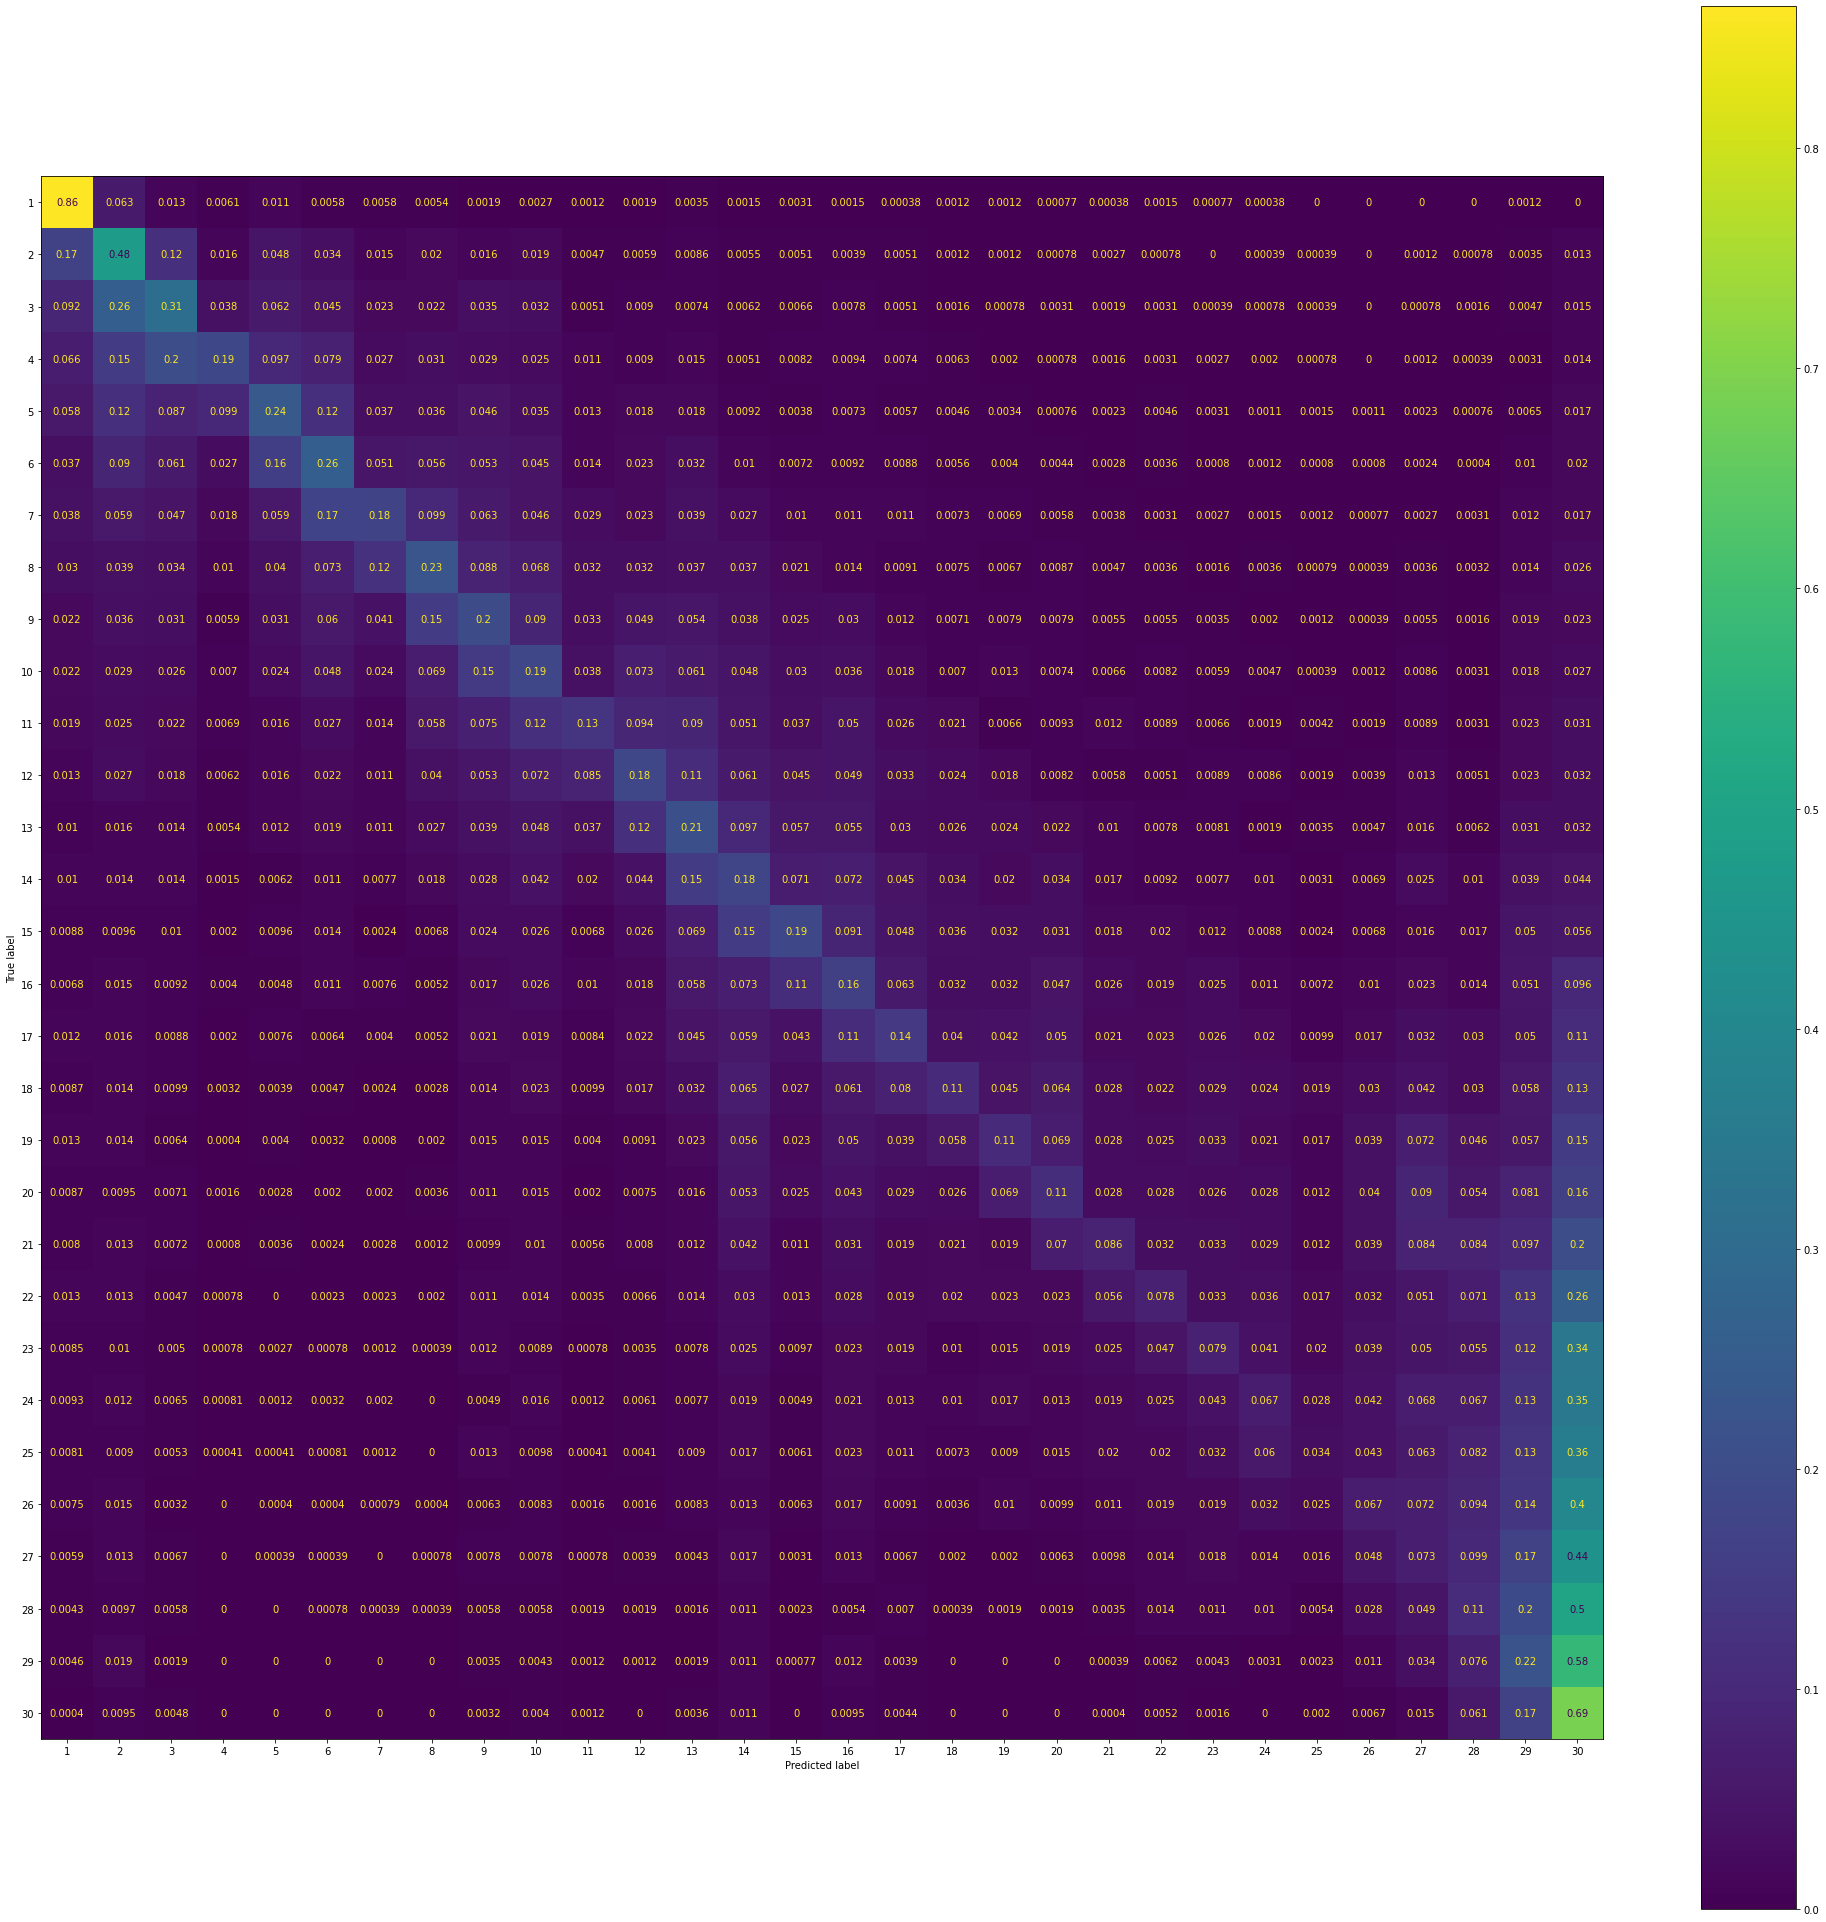

In [108]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(35,35))
disp.plot(ax = ax)

In [109]:
train_label.describe()

count    230161.000000
mean         15.505094
std           8.661000
min           1.000000
25%           8.000000
50%          15.000000
75%          23.000000
max          30.000000
Name: sum_days_active, dtype: float64

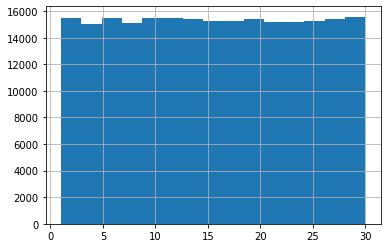

In [110]:
train_label.hist(bins=15)

In [111]:
submit_pool = Pool(submit_data.select(*vars).toPandas(),
                 cat_features=cat_vars,
                 text_features=text_vars,
                 )

In [112]:
preds= model.predict(submit_pool)
pd.DataFrame(preds).describe()#.hist()

,0
count,551472.000000
mean,12.892234
std,10.452480
min,1.000000
25%,3.000000
50%,10.000000
75%,22.000000
max,30.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3652535590>]],
      dtype=object)

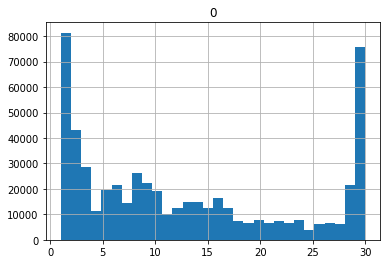

In [113]:
pd.DataFrame(preds).hist(bins=30)

In [114]:
result = pd.DataFrame(model.predict_proba(submit_pool))#.round(4)#.to_csv("test_inner.csv.gz",compression='gzip',index=False,header=False)


In [115]:
result.shape

(551472, 30)

In [116]:
result.loc[:,:29].round(4).to_csv("drive/MyDrive/MeLi-2021/results/challenger.csv.gz",compression='gzip',index=False,header=False)


In [117]:
result = pd.read_csv("drive/MyDrive/MeLi-2021/results/challenger.csv.gz",header=None)
winner = pd.read_csv("drive/MyDrive/MeLi-2021/results/test_inner (16).csv.gz",header=None)

In [118]:
result.idxmax(axis=1).describe()

count    551472.000000
mean         11.886779
std          10.450049
min           0.000000
25%           2.000000
50%           9.000000
75%          21.000000
max          29.000000
dtype: float64

In [119]:
winner.idxmax(axis=1).describe()

count    551472.000000
mean         19.563399
std          12.809139
min           0.000000
25%           3.000000
50%          29.000000
75%          29.000000
max          29.000000
dtype: float64

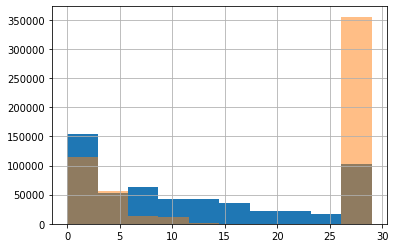

In [120]:
result.idxmax(axis=1).hist()
winner.idxmax(axis=1).hist(alpha=0.5)

In [121]:
np.corrcoef(result.idxmax(axis=1),winner.idxmax(axis=1))

array([[1.        , 0.44831588],
       [0.44831588, 1.        ]])